In [2]:
# Import important libraries
import pandas as pd
from datasets import load_dataset 
import transformers
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import os
import wandb

import gc
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations as A
import shutil
import json
from PIL import Image
import requests
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
wandb.init(
    # set the wandb project where this run will be logged
    project="image captioning",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 5e-5,
    "architecture": "GIT",
    "dataset": "ROCO",
    "epochs": 5,
    }
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
# Read CSV dataset from Pandas
df_train = pd.read_csv('dataset/roco-dataset/all_data/train/radiologytraindata.csv', delimiter=',') #, nrows = nRowsRead
df_train.dataframeName = 'radiologytestdata.csv'
nRow, nCol = df_train.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 65450 rows and 3 columns


In [7]:
# Display first 5 columns of dataframe
df_train.head()

,id,name,caption
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...


In [16]:
# Search those captiones which contains "chest x-ray" words
mask = df_train['caption'].str.contains('chest x-ray', case=False)
filtered_df = df_train[mask]
filtered_df.head()

,id,name,caption
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ..."
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ..."
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n
307,ROCO_00383,PMC5018069_gr1.jpg,Chest X-ray on the day of admission showing d...


In [17]:
# Create "images" column to create full path for images
filtered_df['images'] = "dataset/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']
filtered_df.head()

/tmp/ipykernel_32/1067852196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']


,id,name,caption,images
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ...",/kaggle/input/roco-dataset/all_data/train/radi...
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...,/kaggle/input/roco-dataset/all_data/train/radi...
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ...",/kaggle/input/roco-dataset/all_data/train/radi...
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n,/kaggle/input/roco-dataset/all_data/train/radi...
307,ROCO_00383,PMC5018069_gr1.jpg,Chest X-ray on the day of admission showing d...,/kaggle/input/roco-dataset/all_data/train/radi...


In [18]:
# Create new directory for training images
folder_path = "dataset/train"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

In [19]:
# Iterate through the DataFrame and move the files to the destination folder
for index, row in filtered_df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    
    # Use shutil.move() to move the file
    shutil.copy(source_file, folder_path)

In [20]:
# Delete extra column from the dataframe
filtered_df = filtered_df.drop(columns=["images", "id"])

In [21]:
# Convert dataframe to json format
captions = filtered_df.apply(lambda row: {"file_name": row["name"], "text": row["caption"]}, axis=1).tolist()

In [22]:
# Save data to json file
with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item))

In [23]:
# Load dataset for training
dataset = load_dataset("imagefolder", data_dir=folder_path, split="train")
dataset

Resolving data files:   0%|          | 0/1736 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-c932947df2bfbd94/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'text'],
    num_rows: 1735
})

 The girl: chest X-ray film, done after admission to hospital, showing increasing bilateral infiltrations of the lung, done after admission.



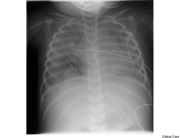

In [24]:
# Visualize the first images and its caption from training data
example = dataset[0]
image = example["image"]
width, height = image.size
print(example["text"])
display(image.resize((int(0.3*width), int(0.3*height))))

In [25]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [26]:
processor = AutoProcessor.from_pretrained("microsoft/git-base")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [27]:
train_dataset = ImageCaptioningDataset(dataset, processor)

In [28]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [29]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [30]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [31]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.0189, grad_fn=<NllLossBackward0>)

In [32]:
%%time
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(5):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    wandb.log({'loss':loss})

    loss.backward()

    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    
  print("Loss:", loss.item())

Epoch: 0
Loss: 0.2010720819234848
Epoch: 1
Loss: 0.05695827677845955
Epoch: 2
Loss: 0.06757723540067673
Epoch: 3
Loss: 0.11957455426454544
Epoch: 4
Loss: 0.21378038823604584
CPU times: user 15min 58s, sys: 6.79 s, total: 16min 5s
Wall time: 14min 2s


In [33]:
#### Create save model path and save the trained model
saved_folder_path = "saved_model/"
if not os.path.exists(saved_folder_path):
    os.mkdir(saved_folder_path)

model.save_pretrained(saved_folder_path)
processor.save_pretrained(saved_folder_path)

In [34]:
### Load the trained model
load_model = AutoModelForCausalLM.from_pretrained(saved_folder_path)
load_processor = AutoProcessor.from_pretrained(saved_folder_path)

In [35]:
# Creating Test Dataset

df_test = pd.read_csv('dataset/roco-dataset/all_data/test/radiology/testdata.csv', delimiter=',')
mask = df_test['caption'].str.contains('chest x-ray', case=False)
filtered_df = df_test[mask]
filtered_df.head()
filtered_df['images'] = "dataset/roco-dataset/all_data/test/radiology/images/" + filtered_df['name']
filtered_df.head()
folder_path = "dataset/test"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)


# Iterate through the DataFrame and move the files to the destination folder
for index, row in filtered_df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    
    # Use shutil.move() to move the file
    shutil.copy(source_file, folder_path)

filtered_df = filtered_df.drop(columns=["images", "id"])
captions = filtered_df.apply(lambda row: {"file_name": row["name"], "text": row["caption"]}, axis=1).tolist()
# add metadata.jsonl file to this folder
with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item))
test_dataset = load_dataset("imagefolder", data_dir=folder_path, split="train")
test_dataset

/tmp/ipykernel_32/3653442878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/test/radiology/images/" + filtered_df['name']


Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-42045c1aa56a8647/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'text'],
    num_rows: 199
})

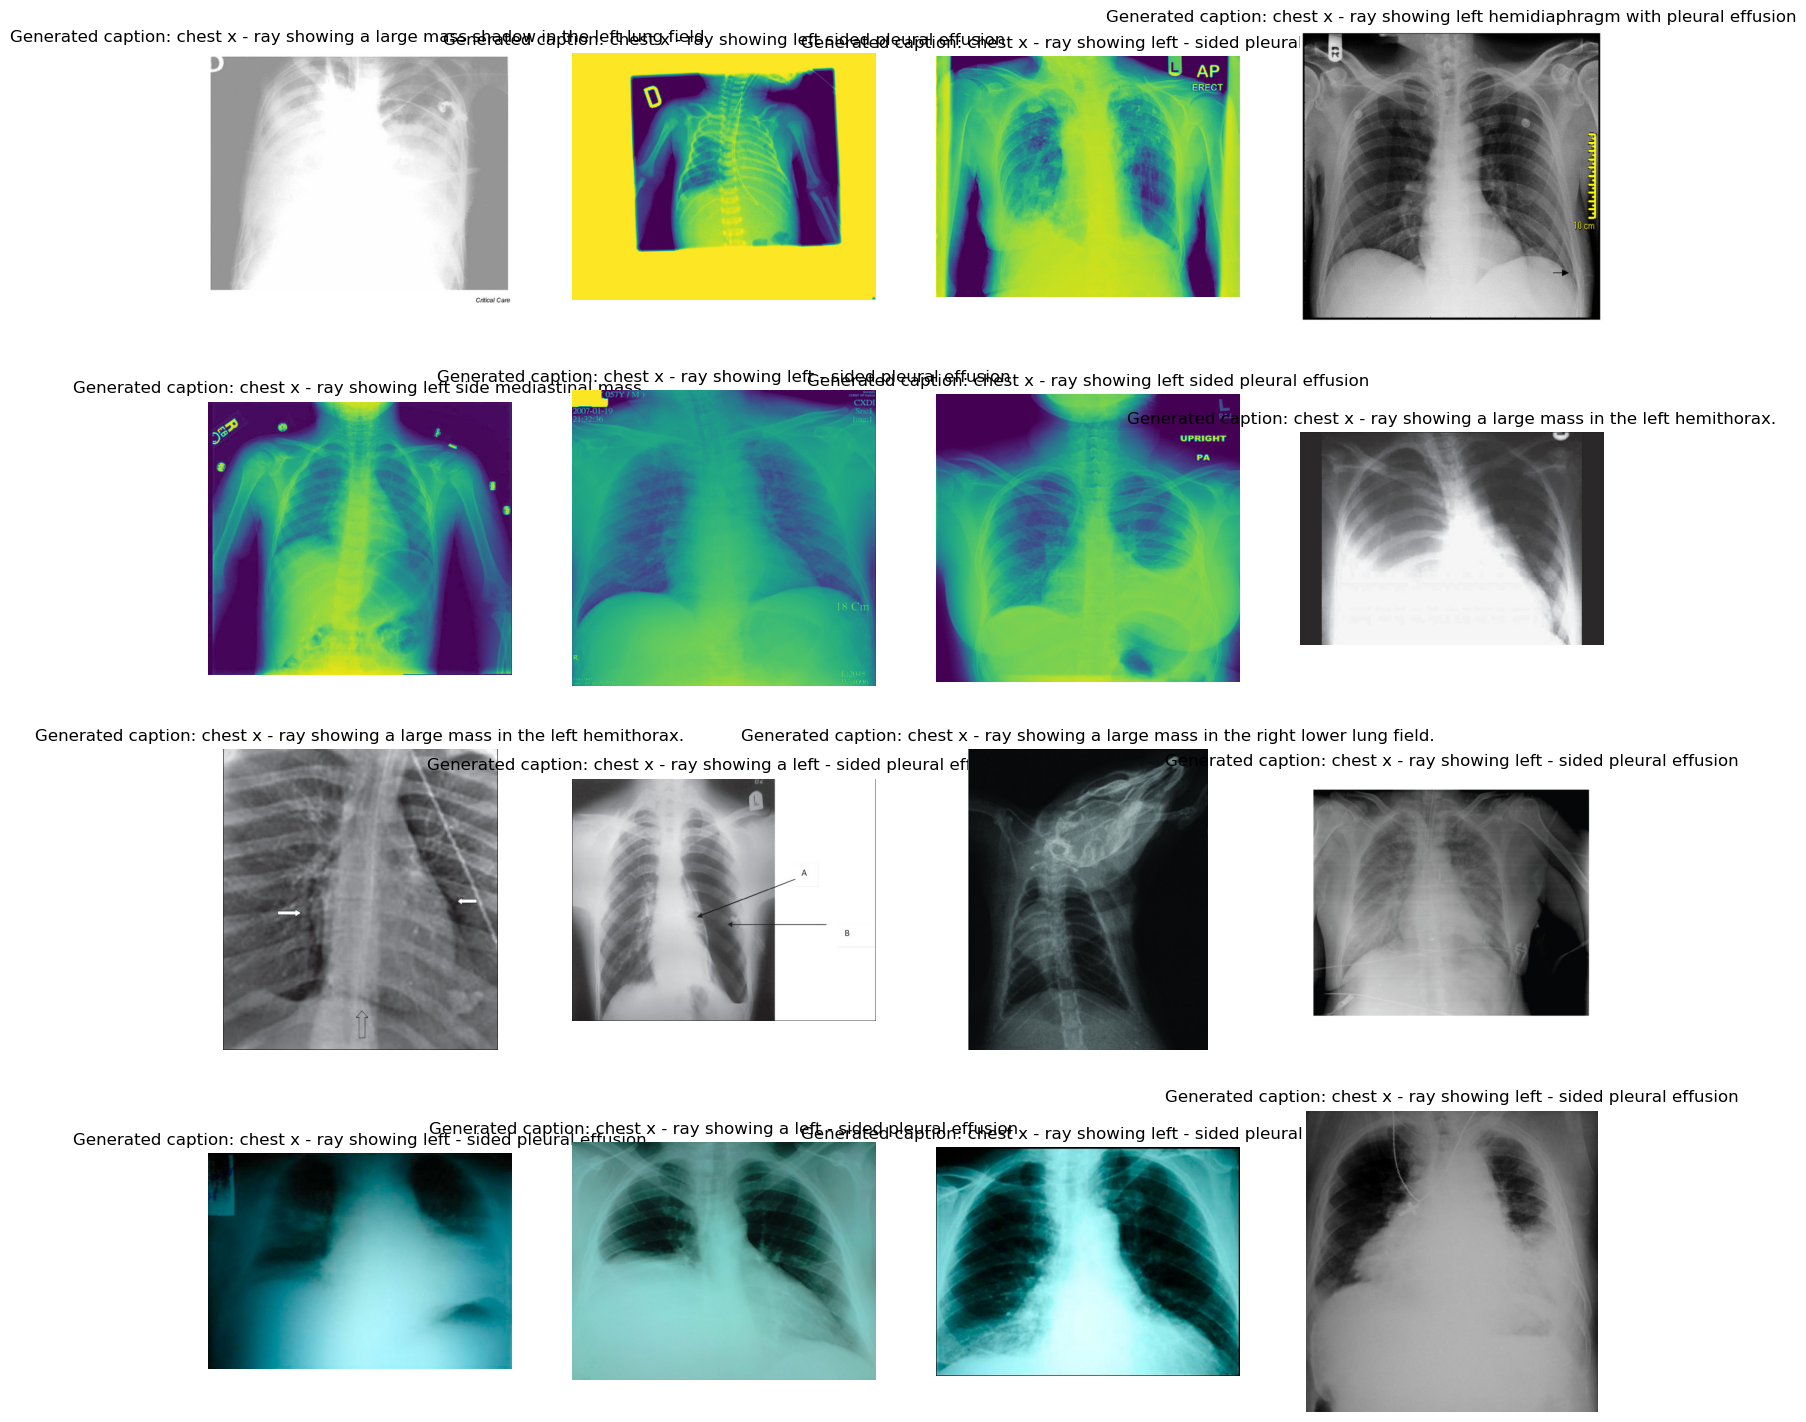

In [36]:
# Predict 16 images of Test Data from trained model
fig = plt.figure(figsize=(18, 18))  # Increase the size of the figure to accommodate 4x4 subplots

# prepare image for the model
for i, example in enumerate(test_dataset):
    image = example["image"]
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    fig.add_subplot(4, 4, i+1)  # Change the size of the grid to 4x4
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Generated caption: {generated_caption}")
    
    if i == 15:  # Display 199 images
        break

plt.show()  # Show the plot after all subplots are added